## Neural networks for segmentation

In [1]:
# ! wget https://www.dropbox.com/s/jy34yowcf85ydba/data.zip?dl=0 -O data.zip
# ! unzip -q data.zip

Your next task is to train neural network to segment cells edges.

Here is an example of input data with corresponding ground truth:

In [2]:
import scipy as sp
import scipy.misc
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

/home/viktor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.
/home/viktor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  import sys


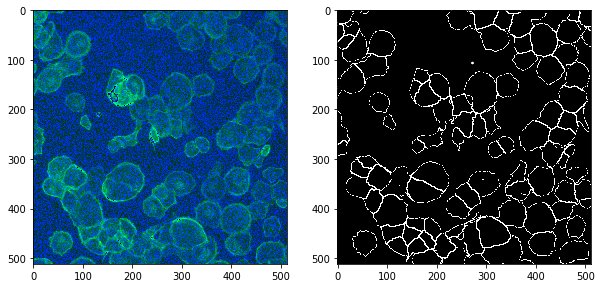

In [3]:
# Human HT29 colon-cancer cells
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
im = sp.misc.imread('BBBC018_v1_images-fixed/train/00735-actin.DIB.bmp')
plt.imshow(im)
plt.subplot(1,2,2)
mask = sp.misc.imread('BBBC018_v1_outlines/train/00735-cells.png')
plt.imshow(mask, 'gray')

This time you aren't provided with any code snippets, just input data and target metric - intersection-over-union (IoU) (see implementation below).

You should train neural network to predict mask of edge pixels (pixels in gt images with value greater than 0).

Use everything you've learnt by now: 
* any architectures for semantic segmentation (encoder-decoder like or based on dilated convolutions)
* data augmentation (you will need that since train set consists of just 41 images)
* fine-tuning

You're not allowed to do only one thing: to train you network on test set.

Your final solution will consist of an ipython notebook with code (for final network training + any experiments with data) and an archive with png images with network predictions for test images (one-channel images, 0 - for non-edge pixels, any non-zero value for edge pixels).

Forestalling questions about baseline... well, let's say that a good network should be able to segment images with iou >= 0.29. This is not a strict criterion of full points solution, but try to obtain better numbers.

Practical notes:
* There is a hard data class imbalance in dataset, so the network output will be biased toward "zero" class. You can either tune the minimal probability threshold for "edge" class, or add class weights to increase the cost of edge pixels in optimized loss.
* Dataset is small so actively use data augmentation: rotations, flip, random contrast and brightness
* Better spend time on experiments with neural network than on postprocessing tricks (i.e test set augmentation).
* Keep in mind that network architecture defines receptive field of pixel. If the size of network input is smaller than receptive field of output pixel, than probably you can throw some layers without loss of quality. It is ok to modify "of-the-shelf" architectures. 

Good luck!

In [4]:
def calc_iou(prediction, ground_truth):
    n_images = len(prediction)
    intersection, union = 0, 0
    for i in range(n_images):
        intersection += np.logical_and(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum() 
        union += np.logical_or(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum()
    return float(intersection) / union

In [5]:
import torch
from torchvision import transforms as T, datasets
from torch.utils.data import Dataset
import torch.nn as nn
import torch.optim as optim

import os, glob, time, copy
from skimage import io

In [6]:
class CancerCellDataset(Dataset):
    def __init__(self, image_path, mask_path, image_transform=None, mask_transform=None):
        super(CancerCellDataset, self).__init__()
        images = glob.glob(os.path.join(image_path, '*.bmp'))
        masks = glob.glob(os.path.join(mask_path, '*.png'))
        self.data = list(zip(images, masks))
        
        self.image_transform = image_transform
        self.mask_transform = mask_transform

    def __getitem__(self, idx):
        image_path, mask_path = self.data[idx]
        
        image = io.imread(image_path)
        mask = io.imread(mask_path)
        
        if self.image_transform is not None:
            image = self.image_transform(image)
        if self.mask_transform is not None:
            mask = self.mask_transform(mask)
        
        mask = (mask > 0).long()
        return image, mask

    def __len__(self):
        return len(self.data)

In [7]:
# Prepare the data

image_dir = './BBBC018_v1_images-fixed/'
mask_dir = './BBBC018_v1_outlines/'

stages = ['train', 'val']

image_transforms = {
    'train': T.Compose([T.ToTensor()]),
    'val'  : T.Compose([T.ToTensor()])}
mask_transforms = {
    'train': T.ToTensor(),
    'val'  : T.ToTensor()}


datasets = {stage: CancerCellDataset(os.path.join(image_dir, stage),
                                     os.path.join(mask_dir, stage),
                                     image_transform=image_transforms[stage],
                                     mask_transform=mask_transforms[stage])
            for stage in stages}

dataloaders = {stage: torch.utils.data.DataLoader(datasets[stage],
                                                  batch_size=8,
                                                  shuffle=False,
                                                  num_workers=16,
                                                  drop_last=False)
               for stage in stages}

In [8]:
# U-net
# https://arxiv.org/pdf/1505.04597.pdf
# U-net implementated similarly to https://github.com/milesial/Pytorch-UNet

class DoubleConv2d(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv2d, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        torch.nn.init.xavier_uniform_(self.conv1.weight)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        torch.nn.init.xavier_uniform_(self.conv2.weight)
        self.relu2 = nn.ReLU()
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        return x

class Down(nn.Module):
    def __init__(self, in_channels):
        super(Down, self).__init__()
        self.max_pool = nn.MaxPool2d(kernel_size=2)
        self.double_conv = DoubleConv2d(in_channels, in_channels*2)
    
    def forward(self, x):
        x = self.max_pool(x)
        x = self.double_conv(x)
        return x

class Up(nn.Module):
    def __init__(self, in_channels):
        super(Up, self).__init__()
#         self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.pad = nn.ZeroPad2d((0,1,0,1))
        self.conv_up = nn.Conv2d(in_channels, in_channels//2, kernel_size=2)
        torch.nn.init.xavier_uniform_(self.conv_up.weight)
        self.relu = nn.ReLU()
        self.double_conv = DoubleConv2d(in_channels, in_channels//2)
    
    def forward(self, x, copy):
        # Up-Convolution
#         x = self.upsample(x)
        x = nn.functional.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        x = self.pad(x)
        x = self.conv_up(x)
        x = self.relu(x)
        
        # Concatenate
        x = torch.cat([copy, x], dim=1)
        
        # Two more Conv layers
        x = self.double_conv(x)
        return x
    
class In(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(In, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        torch.nn.init.xavier_uniform_(self.conv.weight)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        return x
    
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.inp = DoubleConv2d(3, 64)
        self.down1 = Down(64)
        self.down2 = Down(128)
        self.down3 = Down(256)
        self.down4 = Down(512)
        self.up1 = Up(1024)
        self.up2 = Up(512)
        self.up3 = Up(256)
        self.up4 = Up(128)
        self.out = nn.Conv2d(64, 2, kernel_size=1)

    def forward(self, x):
        x1 = self.inp(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.out(x)
#         x = x - x.max(dim=1, keepdim=True)[0]
#         x = x.log_softmax(dim=1)
#         x = x.softmax(dim=1)
#         x = x.sigmoid()
        return x

In [9]:
# Training loop
loss_history = {'train': [], 'val': []}
best_acc = 0.0

def train_model(model, criterion, optimizer, scheduler, num_epochs=10, return_last=False):
    since = time.time()

    global best_model_wts
    best_model_wts = copy.deepcopy(model.state_dict())
    
    global best_acc
    best_acc = 0.0
    
    scheduler_metrics = np.inf

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            since_epoch = time.time()
        
            if phase == 'train':
                scheduler.step(scheduler_metrics)
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, masks in dataloaders[phase]:
                inputs = inputs.to(device)
                masks = masks.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    masks.squeeze_(dim=1)
            
                    loss = criterion(outputs, masks)
    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
#                         break
#             break

                # statistics
#                 running_loss += loss.item() * inputs.size(0)
#                 running_corrects += torch.sum(preds == masks.data)

#             epoch_loss = running_loss / dataset_sizes[phase]
#             epoch_acc = running_corrects.double() / dataset_sizes[phase]

#             time_stage = time.time() - since_epoch
#             print('{} Loss: {:.4f} Acc: {:.4f} Time: {:.1f} sec'.format(
#                 phase, epoch_loss, epoch_acc, time_stage))
            
#             if phase == 'train':
#                 scheduler_metrics = epoch_loss
            
#             loss_history[phase].append(epoch_loss)

#             # deep copy the model
#             if phase == 'val' and epoch_acc > best_acc:
#                 best_acc = epoch_acc
#                 best_model_wts = copy.deepcopy(model.state_dict())

#         print()

#     time_elapsed = time.time() - since
#     print('Training complete in {:.0f}m {:.0f}s'.format(
#         time_elapsed // 60, time_elapsed % 60))
#     print('Best val Acc: {:4f}'.format(best_acc))

#     # load best model weights
#     if return_last == False:
#         model.load_state_dict(best_model_wts)
    return model

In [10]:
# device = torch.device("cuda:0")
device = torch.device("cpu")

In [11]:
net = UNet()
net = net.to(device)

# criterion = nn.NLLLoss()
criterion = nn.CrossEntropyLoss()

# optimizer = optim.Adam(net.parameters(), lr=0.0001)#, weight_decay=0.00001)
optimizer = optim.SGD(net.parameters(), lr=0.1)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
net = train_model(net, criterion, optimizer, scheduler, num_epochs=1)

Epoch 0/0
----------


In [12]:
for name, param in net.named_parameters():
    if param.requires_grad:
        print(name)
#         print(torch.isnan(param).any())
        print(param)

inp.conv1.weight
Parameter containing:
tensor([[[[ 1.3478e-02,  9.6523e-02,  7.5104e-02],
          [-4.1795e-02, -4.6014e-02, -4.8336e-02],
          [-4.9234e-02,  3.2252e-02, -1.5611e-02]],

         [[ 9.5232e-02,  6.6848e-02, -1.2457e-02],
          [ 6.9491e-02, -4.7632e-02,  2.5803e-02],
          [ 1.6940e-02, -9.5978e-02, -4.5926e-03]],

         [[ 3.9908e-02,  6.8757e-02,  8.8393e-02],
          [ 9.1908e-02,  7.3375e-02, -1.8833e-03],
          [-6.8269e-02,  3.2416e-02,  8.5171e-02]]],


        [[[ 2.7412e-02,  5.2216e-02,  6.8013e-02],
          [-2.2945e-02, -6.7215e-02,  7.9057e-02],
          [-6.5070e-02, -2.0580e-02, -4.8248e-02]],

         [[ 4.8356e-04, -7.6814e-02, -7.5119e-02],
          [-5.9898e-02,  8.0416e-02,  9.5856e-02],
          [-6.7709e-02,  2.0008e-02, -2.1191e-02]],

         [[-4.8671e-02, -1.9723e-02, -9.9019e-02],
          [ 6.2213e-02, -8.0505e-03, -2.5593e-02],
          [-8.9159e-02,  7.7039e-02, -5.1994e-02]]],


        [[[ 3.3870e-02,  4.

In [ ]:
for name, param in net.named_parameters():
    if param.requires_grad:
        print(name)
#         print(torch.isnan(param).any())
        print(param)